# Predicting NBA Regular Season Record Using Lasso Regression

##### Goals:
- Use lasso regression on data from prior NBA seasons to determine which statistics are most important in predicting a team's regular season record

##### Project Sections: 
1. Import Packages
2. Clean Data
3. Explore Data with Visualizations
4. Train and Test a Lasso Regression Model
5. Bonus Analysis of Timberwolves 2021-2022 Season

##### Data:
- Downloaded from https://www.basketball-reference.com/
- 150 observations: 30 NBA teams' data from the following 5 regular seasons: 2015-2016, 2016-2017, 2017-2018, 2018-2019, 2020-2021
- 1 response variable: 
    - W: Regular season wins
- 31 predictor variables:
    - MP: Average minutes played per game
    - FG: Average number of field goals per game
    - FGA: Average number of field goal attempts per game
    - FG%: Field goal percentage
    - 3P: Average 3 point shots made per game
    - 3PA: Average 3 point shots attempts per game
    - 3P%: 3 point shot percentage
    - 2P: Average 2 point shots made per game
    - 2PA: Average 2 point shot attempts per game
    - 2P%: 2 point shot percentage
    - FT: Average free throws made per game
    - FTA: Average free throws attempted per game
    - FT%: Free throw percentage
    - ORB: Average offensive rebounds per game
    - DRB: Average defensive rebounds per game
    - TRB: Average total rebounds per game
    - AST: Average assists per game
    - STL: Average steals per game
    - BLK: Average blocks per game
    - TOV: Average turnovers per game
    - PF: Average personal fouls per game
    - PTS: Average points scored per game
    - Age: Average age of the players on the team
    - eFG%: Effective field goal percentage - similar to FG% except more weight is given to 3 pointers than 2 pointers
    - TOV%: Turnover percentage - number of turnovers per 100 plays
    - ORB%: Offensive rebound percentage 
    - FT/FGA: Free throws per field goal attempt
    - OeFG%: Opponents' effective field goal percentage
    - OTOV%: Opponents' turnover percentage
    - DRB%: Defensive rebound percentage 
    - OFT/FGA: Opponents' free throws per field goal attempt


## 1. Import Packages

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt 
import seaborn as sns
import os
import re
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV

## 2. Clean Data

We analyze data from the 5 most recent past NBA seasons not including the 2019-2020 season.  Because not all teams played the same number of games during the NBA 2019-2020 season, we exclude this data to avoid introducing unecessary variance into our analysis.  We also standardize the Wins response variable since the 2015-2016, 2016-2017, 2017-2018, and 2018-2019 seasons consisted of more games than the 2020-2021 season (82 vs. 72 games, respectively).

In [2]:
# Scrape regular season data from basketball-reference.com
# 2015-2016
season_16 = pd.read_html('https://www.basketball-reference.com/leagues/NBA_2016.html#advanced-team')
# 2016-2017
season_17 = pd.read_html('https://www.basketball-reference.com/leagues/NBA_2017.html#advanced-team')
# 2017-2018
season_18 = pd.read_html('https://www.basketball-reference.com/leagues/NBA_2018.html#advanced-team')
# 2018_2019
season_19 = pd.read_html('https://www.basketball-reference.com/leagues/NBA_2019.html#advanced-team')
# 2020_2021
season_21 = pd.read_html('https://www.basketball-reference.com/leagues/NBA_2021.html#advanced-team')

In [3]:
# Simple per game stats
pg_season_16 = season_16[4][:30].drop(columns='Rk').drop(columns='G')
pg_season_17 = season_17[4][:30].drop(columns='Rk').drop(columns='G')
pg_season_18 = season_18[4][:30].drop(columns='Rk').drop(columns='G')
pg_season_19 = season_19[4][:30].drop(columns='Rk').drop(columns='G')
pg_season_21 = season_21[4][:30].drop(columns='Rk').drop(columns='G')

# Advanced stats
adv_season_16 = season_16[10][[u'Unnamed: 1_level_0',u'Unnamed: 2_level_0',u'Unnamed: 3_level_0','Offense Four Factors','Defense Four Factors']][:30].droplevel(0,axis=1)
adv_season_16.columns = ['Team','Age','W','eFG%','TOV%','ORB%','FT/FGA','OeFG%','OTOV%','DRB%','OFT/FGA']
adv_season_17 = season_17[10][[u'Unnamed: 1_level_0',u'Unnamed: 2_level_0',u'Unnamed: 3_level_0','Offense Four Factors','Defense Four Factors']][:30].droplevel(0,axis=1)
adv_season_17.columns = ['Team','Age','W','eFG%','TOV%','ORB%','FT/FGA','OeFG%','OTOV%','DRB%','OFT/FGA']
adv_season_18 = season_18[10][[u'Unnamed: 1_level_0',u'Unnamed: 2_level_0',u'Unnamed: 3_level_0','Offense Four Factors','Defense Four Factors']][:30].droplevel(0,axis=1)
adv_season_18.columns = ['Team','Age','W','eFG%','TOV%','ORB%','FT/FGA','OeFG%','OTOV%','DRB%','OFT/FGA']
adv_season_19 = season_19[10][[u'Unnamed: 1_level_0',u'Unnamed: 2_level_0',u'Unnamed: 3_level_0','Offense Four Factors','Defense Four Factors']][:30].droplevel(0,axis=1)
adv_season_19.columns = ['Team','Age','W','eFG%','TOV%','ORB%','FT/FGA','OeFG%','OTOV%','DRB%','OFT/FGA']
adv_season_21 = season_21[10][[u'Unnamed: 1_level_0',u'Unnamed: 2_level_0',u'Unnamed: 3_level_0','Offense Four Factors','Defense Four Factors']][:30].droplevel(0,axis=1)
adv_season_21.columns = ['Team','Age','W','eFG%','TOV%','ORB%','FT/FGA','OeFG%','OTOV%','DRB%','OFT/FGA']

# Merge simple per game stats tables to advanced stats tables
season1_16 = pg_season_16.merge(adv_season_16, left_on='Team', right_on='Team')
season1_17 = pg_season_17.merge(adv_season_17, left_on='Team', right_on='Team')
season1_18 = pg_season_18.merge(adv_season_18, left_on='Team', right_on='Team')
season1_19 = pg_season_19.merge(adv_season_19, left_on='Team', right_on='Team')
season1_21 = pg_season_21.merge(adv_season_21, left_on='Team', right_on='Team')

# Standard normalize Wins variable in each season
season1_16['W'] = (season1_16['W']-season1_16['W'].mean())/season1_16['W'].std()
season1_17['W'] = (season1_17['W']-season1_17['W'].mean())/season1_17['W'].std()
season1_18['W'] = (season1_18['W']-season1_18['W'].mean())/season1_18['W'].std()
season1_19['W'] = (season1_19['W']-season1_19['W'].mean())/season1_19['W'].std()
season1_21['W'] = (season1_21['W']-season1_21['W'].mean())/season1_21['W'].std()

# Append data from the 5 seasons together
season_data = season1_16.append(season1_17).append(season1_18).append(season1_19).append(season1_21).drop(columns=['Team']).reset_index(drop=True)

## 3. Explore Data with Visualizations

In [4]:
# Confirm that our data set has the correct number of rows (5 seasons x 30 teams)
season_data.shape[0]

150

In [5]:
# Confirm that none of our variables have null values
season_data.isnull().sum()

MP         0
FG         0
FGA        0
FG%        0
3P         0
3PA        0
3P%        0
2P         0
2PA        0
2P%        0
FT         0
FTA        0
FT%        0
ORB        0
DRB        0
TRB        0
AST        0
STL        0
BLK        0
TOV        0
PF         0
PTS        0
Age        0
W          0
eFG%       0
TOV%       0
ORB%       0
FT/FGA     0
OeFG%      0
OTOV%      0
DRB%       0
OFT/FGA    0
dtype: int64

In [6]:
# All of our stats variables are already floats so there is no need to transform variables into floats
season_data.dtypes

MP         float64
FG         float64
FGA        float64
FG%        float64
3P         float64
3PA        float64
3P%        float64
2P         float64
2PA        float64
2P%        float64
FT         float64
FTA        float64
FT%        float64
ORB        float64
DRB        float64
TRB        float64
AST        float64
STL        float64
BLK        float64
TOV        float64
PF         float64
PTS        float64
Age        float64
W          float64
eFG%       float64
TOV%       float64
ORB%       float64
FT/FGA     float64
OeFG%      float64
OTOV%      float64
DRB%       float64
OFT/FGA    float64
dtype: object

#### Analyze Correlations between Variables:
We find that the following statistics are highly correlated, i.e., they have a Pearson correlation coefficient greater than .9 or less than -.9:
- 3P correlated with 3PA
    - We are not surprised that as 3 pt shot attempts increases 3 pt shots made increases
    - We throw out 3PA and keep 3P since 3P is more correlated with wins W
- 2P% correlated with eFG%
    - Both 2P% and eFG% are very closely related to FG%, so we are not surprised that these two statistics are correlated
    - We throw out 2P% and keep eFG% since eFG% is more correlated with wins W
- ORB correlated with ORB%
    - We are not surprised that a team that averages many offensive rebounds per game is highly efficient at rebounding their missed shots, i.e, has a high ORB%
    - We keep ORB% and throw out ORB since ORB% is more correlated with W
- TOV correlated with TOV%
    - We are not surprised that a team that averages many turnovers per game has a high TOV%
    - TOV is marginally more correlated with W, so we throw out TOV% and keep TOV
- FT/FGA correlated with FT 
    - We are not surprised that a team that averages a high number of free throws per field goal attempt shoots many free throws and makes many free throws
    - We throw out FT/FGA and keep FT since FT is marginally more correlated with W
- FT correlated with FTA and FT/FGA
    - We are not surprised that as FT made increases as free throws attempted and free throws per field goal attempt increases
    - We have already thrown out FT/FGA.  Now we throw out FTA and keep FT since FT is more correlated with W

In [7]:
# Turn column names into a list
corr_columns = season_data.columns.tolist()
# Find variables that have correlation > .9 or correlation < -.9 with at least one other variable
high_corr = (season_data.corr().abs() > .9).sum() > 1
# Create a list out of the high_corr variables
high_corr_columns = [i for indx,i in enumerate(corr_columns) if high_corr[indx] == True]
# Find correlations between high_corr variables and the W variable
season_data[high_corr_columns + ['W']].corr()

,3P,3PA,2P%,FT,FTA,ORB,TOV,eFG%,TOV%,ORB%,FT/FGA,W
3P,1.000000,0.972861,0.643836,-0.079891,-0.139909,-0.207544,-0.083031,0.717416,-0.205898,-0.268928,-0.210042,0.306335
3PA,0.972861,1.000000,0.606188,-0.055462,-0.082679,-0.158670,-0.031067,0.601934,-0.175658,-0.266584,-0.198662,0.177568
2P%,0.643836,0.606188,1.000000,0.057377,0.003309,-0.245688,0.063216,0.919864,-0.043877,-0.142683,-0.040136,0.520764
FT,-0.079891,-0.055462,0.057377,1.000000,0.912032,0.226641,0.078342,-0.013647,0.007226,0.270982,0.953911,0.153232
FTA,-0.139909,-0.082679,0.003309,0.912032,1.000000,0.334357,0.227505,-0.111491,0.137228,0.334348,0.873129,0.057868
ORB,-0.207544,-0.158670,-0.245688,0.226641,0.334357,1.000000,0.194512,-0.306531,0.045430,0.930746,0.112585,-0.028182
TOV,-0.083031,-0.031067,0.063216,0.078342,0.227505,0.194512,1.000000,-0.046933,0.942440,0.214926,0.087589,-0.260438
eFG%,0.717416,0.601934,0.919864,-0.013647,-0.111491,-0.306531,-0.046933,1.000000,-0.117318,-0.172180,-0.091069,0.636454
TOV%,-0.205898,-0.175658,-0.043877,0.007226,0.137228,0.045430,0.942440,-0.117318,1.000000,0.142426,0.114614,-0.248213
ORB%,-0.268928,-0.266584,-0.142683,0.270982,0.334348,0.930746,0.214926,-0.172180,0.142426,1.000000,0.225588,0.159569


In [8]:
# Drop correlated columns referenced above
season_data1 = season_data.drop(columns=['3PA','2P%','ORB','TOV%','FT/FGA','FTA'])

After removing variables that had a PCC greater than .9 or less than -.9 with other another variable, we now proceed to remove variables that have PCC greater than .7 or less than -.7.  We could have removed variables with PCC greater than .7 or less than -.7 in 1 step instead of 2.  However, removing variables in 2 steps allows us to work with smaller data sets that are easier to analyze.

- eFG% correlated with FG, FG%, 3P, PTS
    - We are not surprised that the latter 4 statistics are correlated with eFG% since all 5 statistics are related to shooting
    - eFG% is more correlated with W than any of the following 4 stats, so we throw these 4 variables out
- FG correlated with FGA, FG%, AST, PTS, eFG%
    - We are not surprised that FG is correlated with AST since when AST increases FG necessarily increases
    - We have already thrown out FG, FG%, and PTS 
- FG% correlated with FG and eFG%
    - We are not surprised that the latter 2 are correlated with FG% since all 3 statistics are related to shooting
    - We have already thrown out FG and FG%
- 3P correlated with 2PA, PTS, eFG%
    - We are not surprised that the latter 3 are correlated with 3P since all 4 are related to shooting
    - We have already thrown out 3P and PTS
- 2P correlated with 2PA
    - We are not surprised that increasing 2 pt shot attempts increases 2 pt shots made
    - 2PA is more correlated with W than 2P is correlated with W, so we throw out 2P
- 2PA correlated with 3P, 2P
    - Interestingly, as 2PA increases 3P decreases.  This makes sense as more 2 pt attempts means fewer 3 pt attempts.
    - We have already thrown out 3P and 2P
- DRB correlated with TRB
    - We are not surprised that total rebounds per game increases as defensive rebounds per game increases
    - DRP is more correlated with W than TRB is correlated with W, so we throw out TRB
- STL correlated with OTOV%
    - We are not surprised that as a team's steals increase the team's opponents turn the ball over more
    - STL is more correlated with W than OTOV% is correlated with W, so we throw out OTOV%
- PF correlated with OFT/FGA
    - We are not surprised that as a team fouls its opponents more its opponents make more three throws per field goal attempt
    - OFT/FGA is more correlated with W than PF is correlated with W, so we throw out PF

In [9]:
# Turn column names of remaining variables into a list
corr_columns1 = season_data1.columns.tolist()
# Find variables that have correlation > .7 or correlation < -.7 with at least one other variable
high_corr1 = (season_data1.corr().abs() > .7).sum() > 1
# Find correlations between high_corr1 variables and the W variable
high_corr_columns1 = [i for indx,i in enumerate(corr_columns1) if high_corr1[indx] == True] + ['W']
# Create correlation matrix
season_data1[high_corr_columns1].corr()

,FG,FGA,FG%,3P,2P,2PA,DRB,TRB,AST,STL,PF,PTS,eFG%,OTOV%,OFT/FGA,W
FG,1.000000,0.726825,0.771789,0.452113,0.447535,-0.035679,0.540763,0.467611,0.737667,0.109194,-0.045813,0.888550,0.752593,-0.220829,-0.268987,0.421540
FGA,0.726825,1.000000,0.125149,0.446355,0.205933,0.000007,0.486354,0.572870,0.441274,-0.008405,0.072880,0.671284,0.263452,-0.292284,-0.193837,-0.026416
FG%,0.771789,0.125149,1.000000,0.241669,0.454538,-0.053478,0.331408,0.147461,0.660595,0.171814,-0.133616,0.663323,0.844710,-0.043753,-0.212714,0.635589
3P,0.452113,0.446355,0.241669,1.000000,-0.595014,-0.865031,0.408844,0.217249,0.423922,-0.075682,-0.049518,0.704784,0.717416,-0.258458,-0.256452,0.306335
2P,0.447535,0.205933,0.454538,-0.595014,1.000000,0.835056,0.076537,0.202090,0.241294,0.176224,0.008187,0.093086,-0.040001,0.062992,0.015446,0.073608
2PA,-0.035679,0.000007,-0.053478,-0.865031,0.835056,1.000000,-0.159402,0.069056,-0.180733,0.069711,0.040568,-0.374102,-0.542842,0.113222,0.154286,-0.217887
DRB,0.540763,0.486354,0.331408,0.408844,0.076537,-0.159402,1.000000,0.831910,0.399874,-0.290719,-0.203784,0.565768,0.434024,-0.576736,-0.464701,0.416958
TRB,0.467611,0.572870,0.147461,0.217249,0.202090,0.069056,0.831910,1.000000,0.216274,-0.224135,-0.050802,0.473173,0.182296,-0.516892,-0.304860,0.319640
AST,0.737667,0.441274,0.660595,0.423922,0.241294,-0.180733,0.399874,0.216274,1.000000,0.238278,-0.043600,0.663081,0.678809,-0.008467,-0.206313,0.333214
STL,0.109194,-0.008405,0.171814,-0.075682,0.176224,0.069711,-0.290719,-0.224135,0.238278,1.000000,0.277439,0.078069,0.076714,0.824234,0.267884,0.152242


In [10]:
# Drop highly correlated variables
season_data2 = season_data1.drop(columns=['FG','FG%','3P','PTS','2P','TRB','OTOV%','PF'])

Now our data set does not contain any two predictor variables with a Pearson correlation coefficient greater than .7 or less -.7, so none of our variables are highly correlated.  The correlation matrix heatmap below also shows that none of the remaining predictor variables are highly correlated with each other.

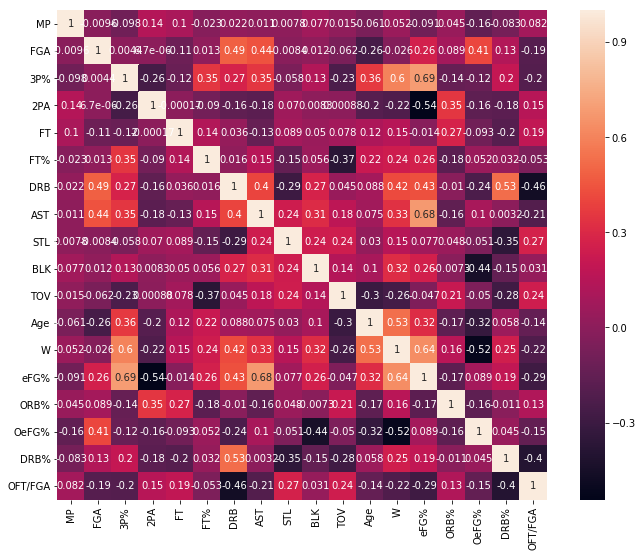

In [11]:
# Correlation matrix
corr_mat = season_data2.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corr_mat,square=True,annot=True);

We now graph scatterplots of our W variable against each predictor variable to see if we need to transform any of our predictor variables.  If any of our graphs show a non-linear trend we would want to use a transformation to make the trend linear.

We do not see any non-linear trends in the graphs below.  Between each predictor variable and Wins there either is no apparent trend or there is a linear trend.  The Wins vs. 3P% graph and the Wins vs. eFG% graph show strong linear trends, for example.

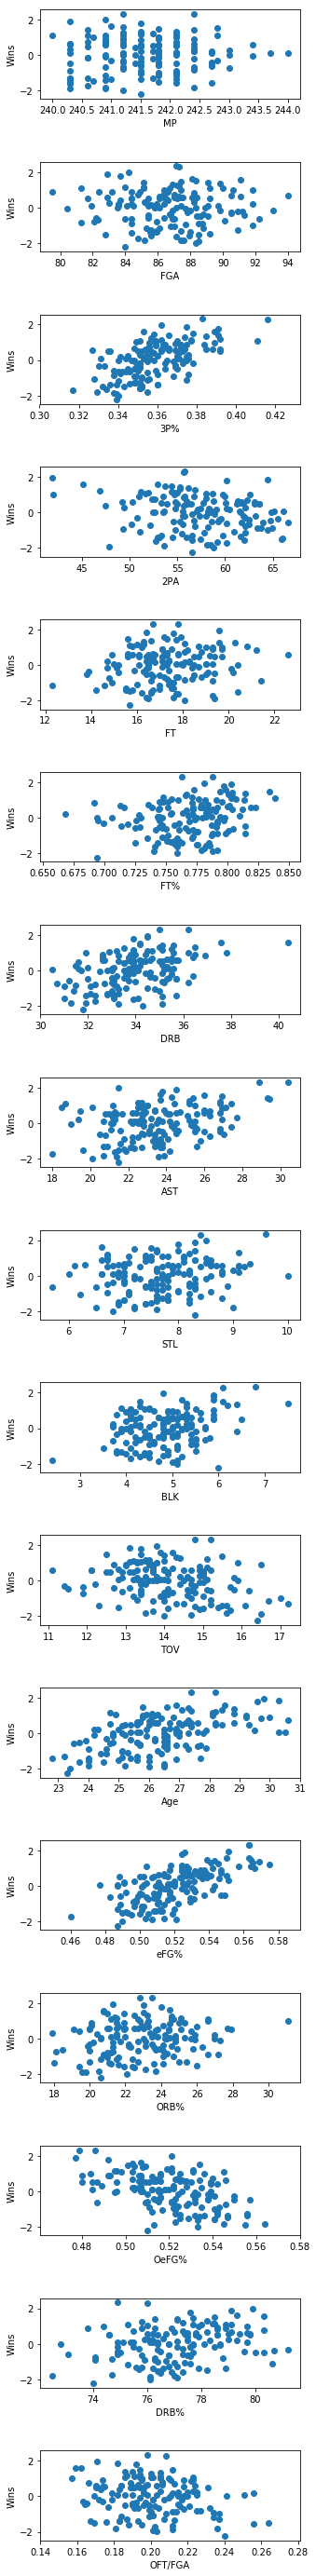

In [12]:
fig, ax = plt.subplots(17,1,figsize=(5,50))
for i in range(season_data2.drop(columns=['W']).shape[1]):
    col_nm = season_data2.drop(columns=['W']).columns.tolist()[i]
    ax[i].scatter(season_data2[col_nm],season_data2['W'])
    ax[i].set_xlabel(col_nm)
    ax[i].set_ylabel('Wins')

plt.subplots_adjust(hspace=.7)
plt.show()

## 4. Train and Test a Lasso Regression Model 

A lasso multiple linear regression model is essentially a the same as a linear regression model except that the magnitudes of the coefficients in the model are constrained.  In a multiple linear regression model multicollinearity between independent variables increases the magnitudes of the coefficients and can cause the following two problems:

1. Difficulty determining which predictor variables have significant relationships with the response variable, i.e., p values of the coefficients are inaccurate
2. Uncertainty that the sizes of the coefficients in the model are accurate

We have chosen to use Lasso regression to predict Wins since this method is known to mitigate the two problems above.

In [13]:
# Randomly select 70% of rows as training data and 30% as testing data
X_train, X_test, y_train, y_test = train_test_split(season_data2.drop(columns=['W']),season_data2['W'],test_size=.3,random_state=12)

Before fitting a lasso regression model we must first standardize our independent variables.  In multiple linear regression an independent variable's coefficient may be significantly smaller than another independent variable's coefficient simply due to the fact that the two independent variables have different scales.  Lasso regression would consider the independent variable with the small coefficient unimportant and would shrink this coefficient to 0.  In order to prevent this outcome, we must standardize our independent variables - transform them to have the same scales - before we use them to fit our lasso regression model.

In [14]:
# Standardize the independent variables in our training and testing sets
scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.fit_transform(X_test)

We use 5-fold cross validation on our training data in order to choose the optimal lambda value for our model.  For each of 10 lambda values - .001, .002, .003, .004, .005, .006, .007, .008 .009 .01 - we train and test our model 5 times and calculate the average mean square error on the 5 testing sets.  We then choose the lambda value that corresponds to the lowest average mean squared error.  The graph below shows that the model with a lambda value of .009 corresponds to the lowest error.

In general, a large lambda causes more of a model's coefficients to shrink to 0 - this causes underfitting, which increases the model's prediction error.  Conversely, a small lambda causes a model's coefficients to grow in magnitude - this causes overfitting, which also increases a model's prediction error.  The graph below displays this phenomenon.

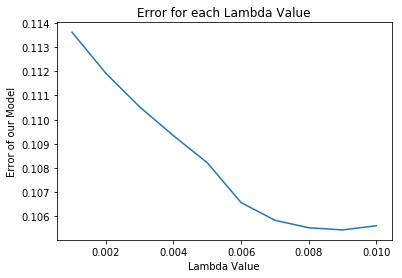

In [15]:
# Parameter tuning using 5-fold cross validation
model_lasso = LassoCV(fit_intercept=False,cv=5,alphas=[.01,.009,.008,.007,.006,.005,.004,.003,.002,.001],random_state=12).fit(X_train_norm, y_train)
mean_mse = pd.Series(pd.DataFrame(model_lasso.mse_path_).transpose().mean())
plt.plot(model_lasso.alphas_,mean_mse)
plt.xlabel('Lambda Value')
plt.ylabel('Error of our Model')
plt.title('Error for each Lambda Value')

plt.show()

The alpha_ attribute of our model confirms that .009 is the optimal lambda value.

In [16]:
print('Otpimal lambda value: ' + str(model_lasso.alpha_))

Otpimal lambda value: 0.009


The coefficients of our lasso regression model are listed below.  We can see that lasso regression shrunk 2 of the 17 coefficients, DRB and AST, to 0.  In other words, Lasso has determined that DRB and AST are not important in predicting regular season wins.  The bar plot below shows the importance of each of our features.  The variables eFG% and OeFG% have a greater impact on regular season wins than any of the other variables.  If all other variables are kept equal, one team that finishes a season with a higher eFG% and a lower OeFG% than another team should generally have a better record than the other team.  The results below make sense intuitively; teams that shoot well and prevent their opponents from shooting well generally have good regular season records.

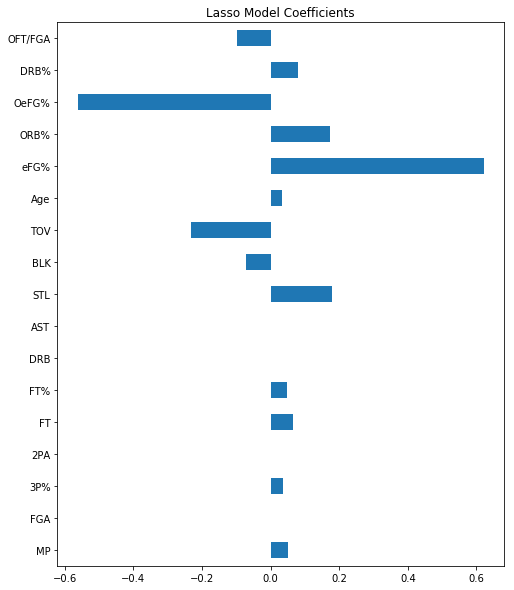

In [19]:
# Create series of coefficient values
model_coef = pd.Series(model_lasso.coef_,index=X_train.columns)
# Create bar graph to show coefficient size
plt.rcParams['figure.figsize'] = (8.0,10.0)
model_coef.plot(kind='barh')
plt.title('Lasso Model Coefficients')
plt.show()

In [20]:
print('Lasso model coefficients:\n')
for i in range(len(X_train.columns)):
    print(str(X_train.columns[i]) + ': ' + str(model_lasso.coef_[i]))

Lasso model coefficients:

MP: 0.05109343137766034
FGA: 0.0
3P%: 0.035724207636854154
2PA: -0.0
FT: 0.06686251452286433
FT%: 0.04853252268116207
DRB: 0.0
AST: -0.0
STL: 0.1795428608585175
BLK: -0.07252361417571311
TOV: -0.23211863793469628
Age: 0.03199855721758406
eFG%: 0.620724278740226
ORB%: 0.17239158360177761
OeFG%: -0.5617086243031979
DRB%: 0.07899159341885914
OFT/FGA: -0.0963134935126002


Below we calculate the $R^2$ value of our model on the training data and on the testing data.  Generally, an $R^2$ larger than .85 indicates that a model fits a data set well.  Therefore, our model fits the training data and testing data well.  As we would expect, the $R^2$ of the model on the training data is greater than the $R^2$ of the model on the testing data.  However, the $R^2$ of the model on the testing data is only 5% lower than the $R^2$ of the model on the testing data, so our model does not lose much accuracy when predicting data it has never seen before.    

In [21]:
print('R^2 of model on training data: ' + str(model_lasso.score(X_train_norm,y_train)))
print('R^2 of model on testing data: ' + str(model_lasso.score(X_test_norm,y_test)))

R^2 of model on training data: 0.9312778299228823
R^2 of model on testing data: 0.8847409955738423


## Timberwolves 2021-2022 Regular Season Analysis

Because our model has identified eFG% and OeFG% as the most significant predictors of regular season record, we use these two statistics to assess the Wolves current standing.

We first graph a histogram of the current regular season wins for all NBA teams.  At the moment each NBA team can be separated into 4 groups based on their records:

1. Teams with fewer than 24 wins - currently 4 teams
2. Teams that have between 24 and 32 wins (inclusive) - currently 8 teams
3. Teams that have between 36 and 52 wins (inclusive) - currently 17 teams
4. Teams with more than 52 wins - currently 1 team

We then create a boxplot for wins for only the teams in group 3 (this group contains the Timberwolves).  We can see that the Wolves are below the 50th percentile in terms of wins in group 3.  

Next, we create boxplots for current eFG% and OeFG% for all NBA teams.  We add data points for the best team in the league, the worst team in the league, and the Timberwolves to each of the two plots.  We are not surprised to that the best team, the Suns, have the highest eFG% and the lowest OeFG% between the 3 teams.  We are also not surprised to see that the worst team, the Rockets, have the lowest eFG% and the highest OeFG% between the 3 teams.  

In [22]:
season_22 = pd.read_html('https://www.basketball-reference.com/leagues/NBA_2022.html#advanced-team')
adv_season_22 = season_22[10][[u'Unnamed: 1_level_0',u'Unnamed: 3_level_0','Offense Four Factors','Defense Four Factors']][:30].droplevel(0,axis=1)
adv_season_22 = adv_season_22.drop(columns=['TOV%','ORB%','FT/FGA','DRB%'])
adv_season_22.columns = ['Team','W','eFG%','OeFG%']
adv_season_22.head()

,Team,W,eFG%,OeFG%
0,Phoenix Suns,60.0,0.553,0.509
1,Boston Celtics,46.0,0.535,0.498
2,Utah Jazz,45.0,0.556,0.520
3,Memphis Grizzlies,52.0,0.522,0.520
4,Golden State Warriors,48.0,0.552,0.510


In [23]:
adv_season_22[adv_season_22['Team'] == 'Minnesota Timberwolves']

,Team,W,eFG%,OeFG%
7,Minnesota Timberwolves,43.0,0.536,0.528


In [24]:
worst_team = adv_season_22.sort_values(by='W').reset_index(drop=True).loc[[0]]
best_team = adv_season_22.sort_values(by='W',ascending=False).reset_index(drop=True).loc[[0]]

In [25]:
wolves = adv_season_22[adv_season_22['Team'] == 'Minnesota Timberwolves']
wolves

,Team,W,eFG%,OeFG%
7,Minnesota Timberwolves,43.0,0.536,0.528


In [26]:
print('Ave number of wins for NBA teams as of 3/27/22: ' + str(adv_season_22['W'].mean()))

Ave number of wins for NBA teams as of 3/27/22: 37.1


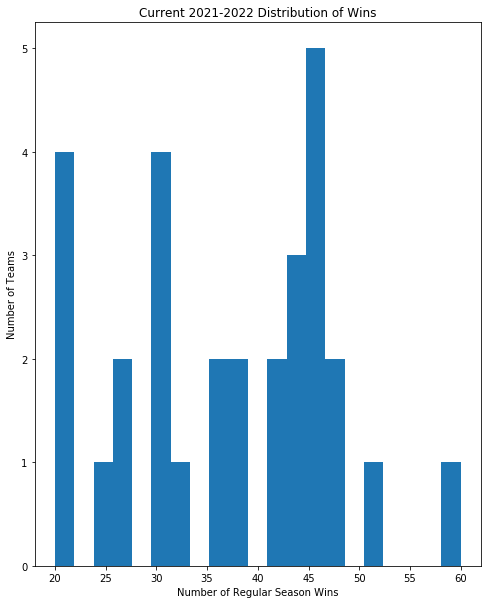

In [27]:
plt.hist(x=adv_season_22['W'],bins=21)
plt.xlabel('Number of Regular Season Wins')
plt.ylabel('Number of Teams')
plt.title('Current 2021-2022 Distribution of Wins')
plt.show()

In [28]:
# Teams with wins between 36 and 52 (inclusive)
wins_36_52 = adv_season_22[(adv_season_22['W'] >= 36) & (adv_season_22['W'] <= 52)].reset_index(drop=True)

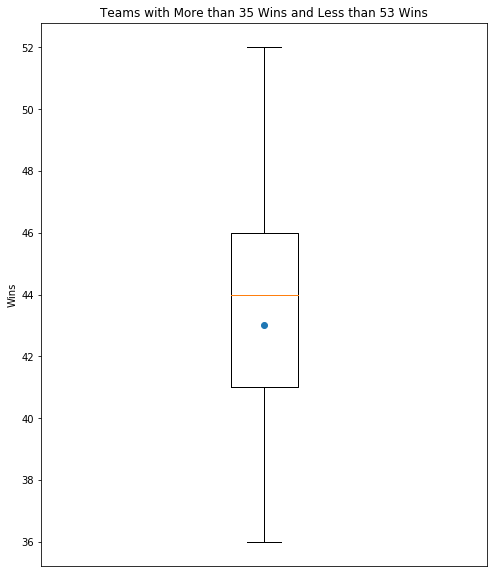

In [29]:
plt.boxplot(wins_36_52['W'])
plt.ylabel('Wins')
plt.xticks([])
plt.scatter([1], wolves['W'],label='Wolves')
plt.title('Teams with More than 35 Wins and Less than 53 Wins')

plt.show()

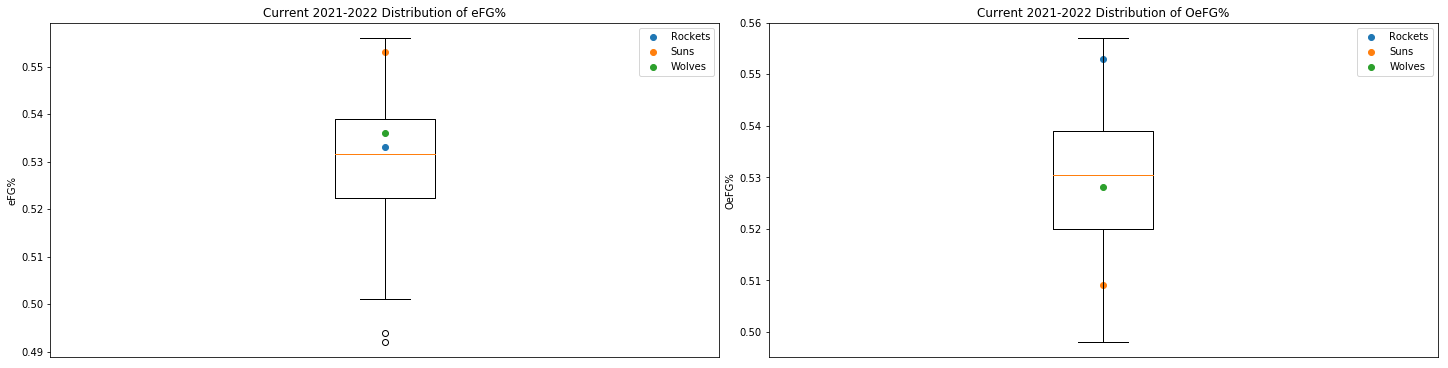

In [30]:
fig,axes = plt.subplots(1,2,figsize=(20,5))

axes[0].boxplot(adv_season_22['eFG%'])
axes[0].set_ylabel('eFG%')
axes[0].scatter([1], worst_team['eFG%'],label='Rockets')
axes[0].scatter([1], best_team['eFG%'],label='Suns')
axes[0].scatter([1], wolves['eFG%'],label='Wolves')
axes[0].legend()
axes[0].set_xticks([])
axes[0].set_title('Current 2021-2022 Distribution of eFG%')

axes[1].boxplot(adv_season_22['OeFG%'])
axes[1].set_ylabel('OeFG%')
axes[1].scatter([1], worst_team['OeFG%'],label='Rockets')
axes[1].scatter([1], best_team['OeFG%'],label='Suns')
axes[1].scatter([1], wolves['OeFG%'],label='Wolves')
axes[1].legend()
axes[1].set_xticks([])
axes[1].set_title('Current 2021-2022 Distribution of OeFG%')

fig.tight_layout(pad=0.3)
plt.show()

##### Conclusions:
When our lasso regression model was run on testing data it predicted regular season wins with an $R^2$ of .88.  Using the rule that an $R^2$ over .85 is good, we can confidently say that our model accurately predicts regular season wins.  Furthermore, eFG% and OeFG% were by far the most significant predictors of regular season wins.  Due to this result, we are not surprised to find that the team that currently has the best record, the Suns, has a better eFG% than the Timberwolves, and the Timberwolves have a better eFG% than the team that currently has the worst record, the Rockets.  We find analogous results when analyzing OeFG%.

*As a Timberwolves fan, I hope the Wolves are highly cogniscent of their nighly eFG% and OeFG% as they wrap up the season.